 # Weight SPAR Stores by Size 

From supermarket dataset, we have: 

size_category: values like "Small", "Medium", "Large" 

We can convert these into numerical weights, for example: 
size_weights = {'Small': 1, 'Medium': 2, 'Large': 3} 

Then calculate a "weighted SPAR presence" instead of just counting how many stores there are.

 

In [2]:
import pandas as pd

# Load the datasets
forecast_df = pd.read_csv('KTZH_area_forecast.csv')
supermarkets_df = pd.read_csv('all_supermarkets_with_size_and_rating.csv')

# Filter only SPAR supermarkets
spar_df = supermarkets_df[supermarkets_df['name'].str.contains('spar', case=False)].copy()

# Define size weights
size_weights = {'Small': 1, 'Medium': 2, 'Large': 3}

# Map size_category to numeric weight
spar_df['size_weight'] = spar_df['size_category'].map(size_weights)

# Group by district and sum the weighted sizes
spar_weighted = spar_df.groupby('district')['size_weight'].sum().reset_index(name='spar_weighted_size')

# Preview the result
spar_weighted.head(12)


,district,spar_weighted_size
0,Affoltern,2
1,Andelfingen,1
2,Bülach,3
3,Dielsdorf,8
4,Dietikon,3
5,Hinwil,1
6,Horgen,6
7,Meilen,1
8,Pfäffikon,1
9,Uster,4


***Weighted Total Supermarket Capacity*** 

We’ll calculate: 

1- Total competitor capacity per district 

2- SPAR capacity per district 

3- Then we can compare SPAR share of total capacity

In [3]:
# Define size weights again
size_weights = {'Small': 1, 'Medium': 2, 'Large': 3, 'Unknown': 1}


# Map size to all supermarkets
supermarkets_df['size_weight'] = supermarkets_df['size_category'].map(size_weights)

# Total capacity per district (all supermarkets)
total_capacity = supermarkets_df.groupby('district')['size_weight'].sum().reset_index(name='total_supermarket_capacity')

# SPAR capacity per district (already done above)
spar_df = supermarkets_df[supermarkets_df['name'].str.contains('spar', case=False)].copy()
spar_df['size_weight'] = spar_df['size_category'].map(size_weights)
spar_capacity = spar_df.groupby('district')['size_weight'].sum().reset_index(name='spar_capacity')

# Merge both into one DataFrame
capacity_df = pd.merge(total_capacity, spar_capacity, on='district', how='left')

# Fill missing SPAR capacity with 0
capacity_df['spar_capacity'] = capacity_df['spar_capacity'].fillna(0)

# Calculate SPAR market share by capacity
capacity_df['spar_capacity_share'] = capacity_df['spar_capacity'] / capacity_df['total_supermarket_capacity']

# Preview result
capacity_df.head(12)
capacity_df.style.format({
    'spar_capacity_share': '{:.2%}'
})


,district,total_supermarket_capacity,spar_capacity,spar_capacity_share
0,Affoltern,19,2,10.53%
1,Andelfingen,13,1,7.69%
2,Bülach,98,3,3.06%
3,Dielsdorf,47,8,17.02%
4,Dietikon,55,3,5.45%
5,Hinwil,47,1,2.13%
6,Horgen,64,6,9.38%
7,Meilen,40,1,2.50%
8,Pfäffikon,33,1,3.03%
9,Uster,66,4,6.06%


In [6]:
#Filter for 2023 actual and 2050 forecast
actual_2023 = forecast_df[(forecast_df['year'] == 2023) & (forecast_df['data type'] == 'Pop_Actual')]
forecast_2050 = forecast_df[(forecast_df['year'] == 2050) & (forecast_df['data type'] == 'Pop_Forecast')]

# Group by district
actual_by_district = actual_2023.groupby('district')['number'].sum().reset_index(name='Pop_Actual')
forecast_by_district = forecast_2050.groupby('district')['number'].sum().reset_index(name='Pop_Forecast')

# Merge the two
population_by_district = pd.merge(actual_by_district, forecast_by_district, on='district')

# Calculate growth rate
population_by_district['growth_rate'] = (
    (population_by_district['Pop_Forecast'] - population_by_district['Pop_Actual']) /
    population_by_district['Pop_Actual']
) * 100

# Display result
population_by_district = population_by_district.sort_values(by='growth_rate', ascending=False)
population_by_district

,district,Pop_Actual,Pop_Forecast,growth_rate
4,Dietikon,97401.0,128861.770,32.300254
9,Uster,139677.0,182505.939,30.662843
10,Winterthur,179830.0,228342.388,26.976805
11,Zürich,432552.0,539635.752,24.756273
8,Pfäffikon,62918.0,78014.774,23.994364
2,Bülach,163636.0,201593.545,23.196329
6,Horgen,130994.0,161132.538,23.007571
0,Affoltern,57558.0,70496.544,22.479141
5,Hinwil,100651.0,122351.769,21.560411
3,Dielsdorf,94931.0,115232.579,21.385616


In [7]:
# Merge population with capacity data
master_df = pd.merge(population_by_district, capacity_df, on='district', how='left')

# Calculate people per spar capacity (adjust for 0 division)
master_df['people_per_spar_unit'] = master_df['Pop_Forecast'] / master_df['spar_capacity'].replace(0, pd.NA)


# Final Score
Want to now include:  
-Forecast population  
-Growth rate  
-Low SPAR capacity share  
-High people per SPAR capacity unit?

| Metric                 | Meaning                                    | Desirable Direction       |
| ---------------------- | ------------------------------------------ | ------------------------- |
| `Pop_Forecast`         | Future demand potential                    | Higher is better          |
| `growth_rate`          | How fast the district is growing           | Higher is better          |
| `spar_capacity_share`  | How much of the market SPAR already owns   | **Lower** is better       |
| `people_per_spar_unit` | How many people each SPAR unit would serve | Higher = more underserved |


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Copy only needed columns for scoring
scoring_df = master_df[['district', 'Pop_Forecast', 'growth_rate', 'spar_capacity_share', 'people_per_spar_unit']].copy()

# Fill any NaNs in people_per_spar_unit with a big number (underserved)
scoring_df['people_per_spar_unit'] = scoring_df['people_per_spar_unit'].fillna(1e6)

# Normalize values between 0 and 1
scaler = MinMaxScaler()
scoring_df[['Pop_Forecast', 'growth_rate']] = scaler.fit_transform(scoring_df[['Pop_Forecast', 'growth_rate']])
scoring_df[['spar_capacity_share']] = 1 - scaler.fit_transform(scoring_df[['spar_capacity_share']])  # lower is better
scoring_df[['people_per_spar_unit']] = scaler.fit_transform(scoring_df[['people_per_spar_unit']])  # higher is better

# Final weighted score (adjust weights if needed)
scoring_df['score'] = (
    scoring_df['Pop_Forecast'] * 0.3 +
    scoring_df['growth_rate'] * 0.3 +
    scoring_df['spar_capacity_share'] * 0.2 +
    scoring_df['people_per_spar_unit'] * 0.2
)

# Sort and display top 5
top_final = scoring_df.sort_values(by='score', ascending=False)

# Display nicely formatted
top_final.head(12).style.format({
    'Pop_Forecast': '{:.2f}',
    'growth_rate': '{:.2f}%',
    'spar_capacity_share': '{:.2%}',
    'people_per_spar_unit': '{:.2f}',
    'score': '{:.3f}'
})


,district,Pop_Forecast,growth_rate,spar_capacity_share,people_per_spar_unit,score
3,Zürich,1.00,0.43%,86.10%,0.30,0.662
0,Dietikon,0.18,1.00%,77.66%,0.25,0.559
1,Uster,0.29,0.88%,73.59%,0.27,0.550
8,Hinwil,0.17,0.19%,100.00%,0.94,0.494
5,Bülach,0.32,0.31%,93.73%,0.46,0.470
2,Winterthur,0.38,0.60%,67.29%,0.16,0.459
11,Meilen,0.18,0.00%,97.50%,1.00,0.449
4,Pfäffikon,0.08,0.37%,93.94%,0.55,0.434
6,Horgen,0.24,0.30%,51.34%,0.11,0.287
7,Affoltern,0.06,0.26%,43.61%,0.18,0.220


We now have a data-driven, weighted score for each district that considers:  
How many people are coming  
How fast it’s growing  
How under-served it is by SPAR

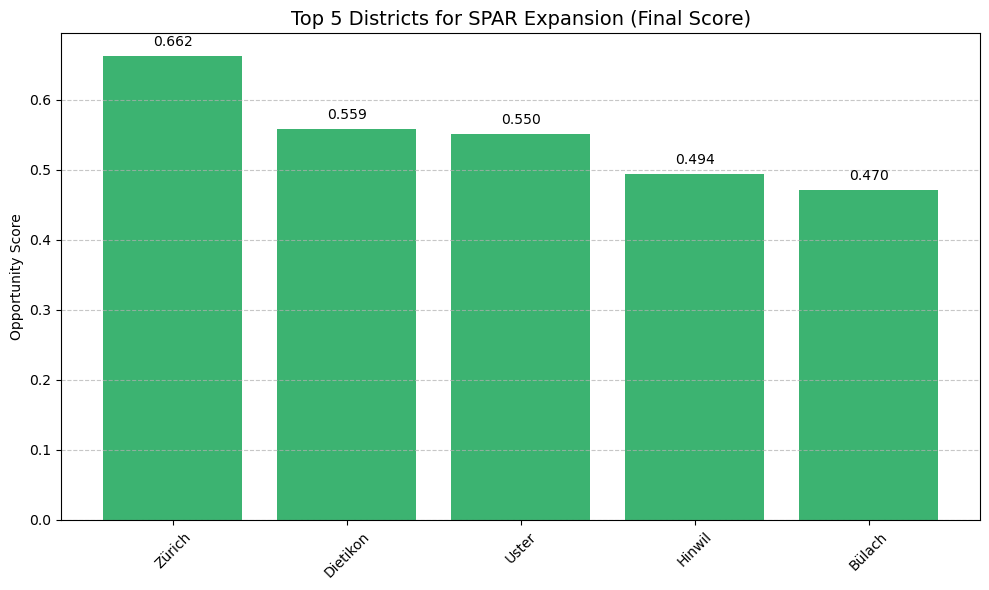

In [9]:
import matplotlib.pyplot as plt

# Get top 5 districts by score
top5 = top_final.head(5)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(top5['district'], top5['score'], color='mediumseagreen')

# Add labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# Style the chart
plt.title('Top 5 Districts for SPAR Expansion (Final Score)', fontsize=14)
plt.ylabel('Opportunity Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
